# Tabular Playground September 2021

# Load Data

In [1]:
import numpy as np
import pandas as pd
test = pd.read_csv('datasets/test.csv')
train = pd.read_csv('datasets/train.csv')

In [2]:
lst_train_dtypes = train.dtypes.value_counts()
print(lst_train_dtypes)

float64    118
int64        2
dtype: int64


All features are float and the index and 'claim' columns are int.  'claim' is the target variable.

# EDA

## Histograms

Taking a quick look at histograms of each feature.

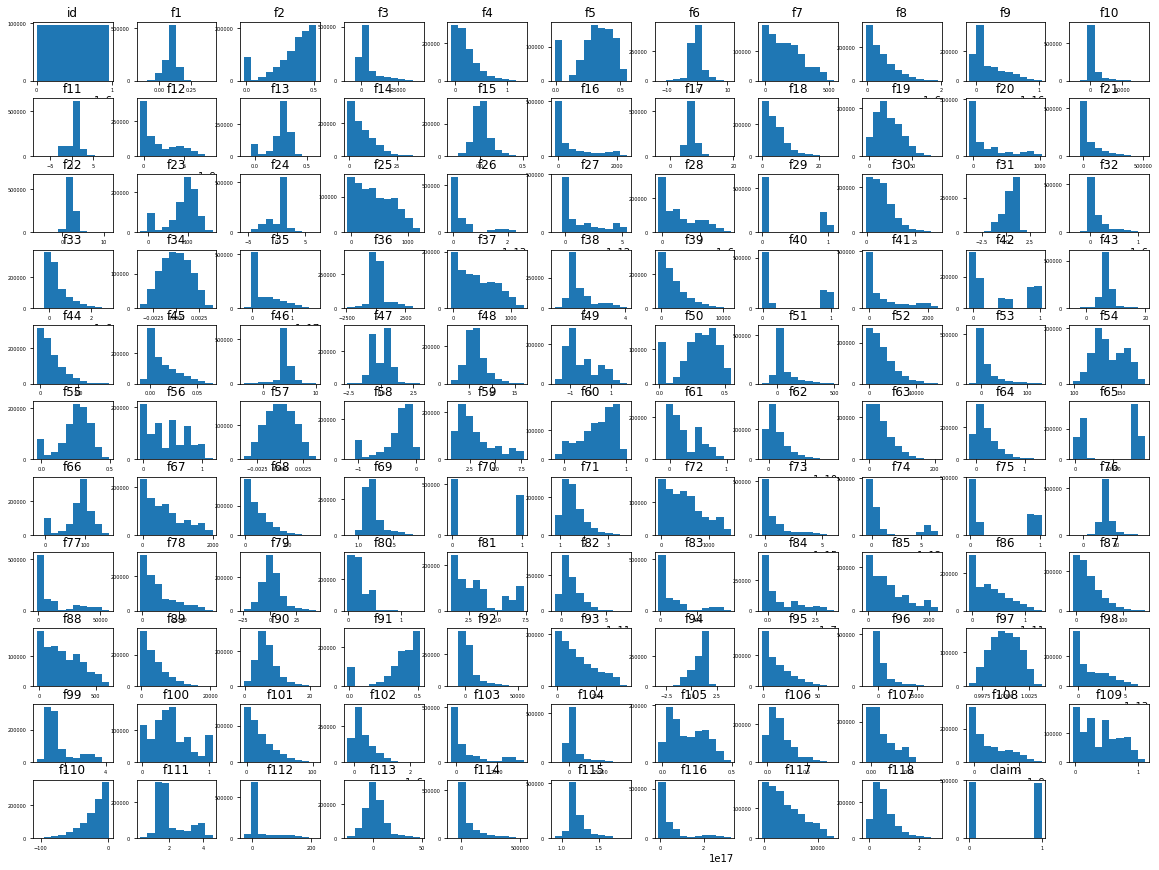

In [3]:
import matplotlib.pyplot as plt
train.hist(figsize=(20,15), grid=False, ylabelsize=5, xlabelsize=5)
plt.show()

There is an extremely wide range of values beween features, spanning orders of magnitude, so some standardization or normalization will be key.  Some appear to be very discrete, e.g. `f40`, `f42`, and so imputation with mean or median may not make sense.

## Missing Values

In [4]:
rows_with_na = train.shape[0] - train.dropna(axis=0).shape[0]
print("There are", rows_with_na, "rows with at least one missing value, out of", train.shape[0], "total rows in the training set.")

There are 598455 rows with at least one missing value, out of 957919 total rows in the training set.


There are many missing values in the dataset, more than half of the rows contain at least one missing value.  I'll now take a quick look at number of missing values per row.

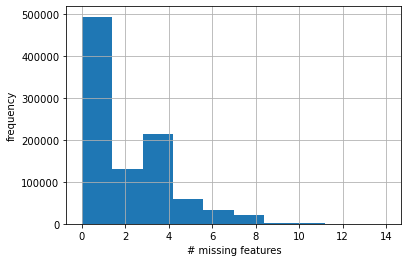

In [5]:
X_train = train.copy()
X_train['num_nan'] = X_train.isnull().sum(axis=1)
X_train.num_nan.hist()
plt.xlabel('# missing features')
plt.ylabel('frequency')
plt.show()

And also looking at the features which are most frequently missing.

In [6]:
feat_nan = train.isnull().sum(axis=0)
feat_nan.sort_values(ascending=False)

f31      15678
f46      15633
f24      15630
f83      15627
f68      15619
         ...  
f104     15198
f2       15190
f102     15168
id           0
claim        0
Length: 120, dtype: int64

All in all, the missing values are fairly evenly spread throughout all features at ~15,000 per feature.  Since there are so many missing values, I will add `num_nan` as a new feature in the FE section below.

# Feature Engineering

In a separate notebook, I've investigated the features using Mutual Information and PCA.  The MI analysis showed that none of the features had a very strong score and the PCA from all features resulted in no potential for dimensionality reduction due to a lack of variation extraction from the PCs, e.g. the percent of variance explained per PC increased linearly.  Because of this, I will add a few features to the dataset and evaluate their usefulness, including:

* `num_nan` - a count of missing values per row
* `sum` - a sum of all features after standardization, excluding missing values.  I plan to use an tree model which can have trouble splitting on a combination of a large number of variables, so this may prove to be a useful feature.
* some other descriptive stats just for completeness sake.

These will be built into the preprocessing pipeline with a custom class so that I can tune their selection like a hyperparameter.

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    #one hyperparameter per new feature
    def __init__(self, add_sum = True, add_num_nan = True, add_ohe_nan = True): #no *args or **kargs
        self.add_sum = add_sum
        self.add_num_nan = add_num_nan
        self.add_ohe_nan = add_ohe_nan
    def fit(self, X, y=None):
        return self #nothing to fit
    def transform(self, X):
        #generate additional features
        if self.add_sum:
            std_scaler = StandardScaler()
            sum_col = X.copy()
            sum_col[np.isnan(sum_col)] = 0
            sum_col = std_scaler.fit_transform(sum_col)
            sum_col = sum_col.sum(axis=1)
            X = np.c_[X, sum_col]
        if self.add_num_nan:
            num_nan = np.isnan(X).sum(axis=1)
            X = np.c_[X, num_nan]
        if self.add_ohe_nan:
            n_og_columns = np.shape(X)[1]-add_sum-add_num_nan # don't include the sum and num_nan columns
            is_nan = np.isnan(X[:, 0:n_og_columns]) * 1
            X = np.c_[X, is_nan]
        return X



In [8]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

add_num_nan = True
add_sum = True
add_ohe_nan = True

prep_pipeline = Pipeline([
    ('attr_adder', CombinedAttributesAdder(add_num_nan=add_num_nan, add_sum=add_sum, add_ohe_nan=add_ohe_nan)),
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

Now splitting the dataset into train, validation and taking a quick look at the new features.

In [9]:
from sklearn.model_selection import train_test_split
train_set, valid_set = train_test_split(train, test_size=0.1)

X_train_prep = train_set.drop(['id', 'claim'], axis=1)
y_train = train_set.claim

#keep track of feature names
X_features = X_train_prep.columns.values.tolist()
if add_sum:
    X_features += ['sum']
if add_num_nan:
    X_features += ['num_nan']
if add_ohe_nan:
    X_features += [str(col) + '_NA' for col in X_train_prep.columns]

#preprocess
X_train_prep = prep_pipeline.fit_transform(X_train_prep)
#convert to dataframe
# runs into an error here, there are too many columns in the data
X_train_prep = pd.DataFrame(X_train_prep, columns=X_features)

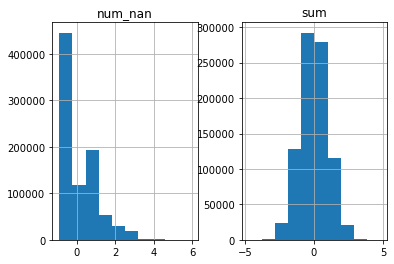

In [10]:
X_train_prep[['num_nan', 'sum']].hist()
plt.show()

# Baseline Models

As a baseline performance check, I'm going to try a few models and see what kind of auc scores I get.  I'll handle hyperparameter tuning in another notebook, as it'll be very resources hungry.

## Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

log_reg = LogisticRegression()

# #evaluating auc on the training set
log_reg.fit(X_train_prep, y_train)
predictions = log_reg.predict(X_train_prep)
log_reg_tr_auc = roc_auc_score(y_train, predictions)

#evaluating auc using cv
log_reg_cv_scores = cross_val_score(log_reg, X_train_prep, y_train,
                        scoring = 'roc_auc', cv=10)

#evaluating against validation set
X_valid_prep = valid_set.drop(['id', 'claim'], axis=1)
y_valid = valid_set.claim
X_valid_prep = prep_pipeline.transform(X_valid_prep)
preds_valid = log_reg.predict(X_valid_prep)
log_reg_valid_auc = roc_auc_score(y_valid, preds_valid)

#quick function to display scores
def display_scores(cv_scores, tr_score, valid_score):
    print("Training Score:", tr_score)
    print("CV Scores:", cv_scores)
    print("Mean CV Score:", cv_scores.mean())
    print("StDev CV Scores:", cv_scores.std())
    print("Validation Score:", valid_score)

display_scores(log_reg_cv_scores, log_reg_tr_auc, log_reg_valid_auc)

Training Score: 0.7373269370759942
CV Scores: [0.7970595  0.80345777 0.8008867  0.79898079 0.79830666 0.79760354
 0.79887122 0.79920046 0.79820093 0.79778696]
Mean CV Score: 0.7990354530505399
StDev CV Scores: 0.0017827596247094828
Validation Score: 0.7366715149616467


# Evaluation

Now to predict the test set with the final model and submit predictions.

In [12]:
final_mod = log_reg

# Preprocessing of test data, get predictions
X_test_ids = test.id
X_test_prep = test.drop('id', axis=1)
X_test_prep = prep_pipeline.transform(X_test_prep)
preds_test = final_mod.predict(X_test_prep)

#export predictions
output = pd.DataFrame({'id': X_test_ids,
                       'claim': preds_test})
output.to_csv('submission.csv', index=False)